In [3]:
import cudaq
import numpy as np
from math import floor
from cudaq import spin
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools
import time
from cudaq import spin
import numpy as np
from scipy.optimize import minimize


## Iterative Quantum Algorithms (IQA)

Iterative Quantum Algorithms (IQA) (https://arxiv.org/abs/2601.21923 ) are a hybrid "quantum-classical" framework. Instead of trying to find the perfect solution in one massive quantum calculation, IQA breaks the problem down into a series of smaller, simpler decisions made one at a time.

### 1. Difference in "Reduction" (Constraint vs. Objective)
The paper focuses on MIS because it has **hard constraints** (two neighbors cannot both be 1).
*   **In MIS:** Fixing one bit to "1" allows you to delete all its neighbors instantly. This causes the problem size to shrink very rapidly.
*   **In LABS:** There are no hard constraints; every bit can be either -1 or 1. Every bit is "connected" to every other bit in a complex, dense web of autocorrelations. Fixing one bit reduces the search space (from $2^n$ to $2^{n-1}$), but it doesn't "delete" other variables the way the MIS algorithm does.


### 3. Which IQA variant would work best for LABS?
The paper discusses two ways to "fix" variables:
1.  **Single-bit fixing:** You look at $\langle \sigma_i^z \rangle$ and fix bit $i$.
2.  **Quadratic fixing:**  This involves looking at the correlation between two bits $\langle \sigma_i^z \sigma_j^z \rangle$.

For LABS, **Quadratic fixing** would likely be much more effective. 



### 4. Potential Advantages for LABS
*   **Precision Management:** LABS is notoriously difficult because the "energy landscape" is incredibly jagged (many deep local minima). Standard QAOA often gets stuck in a "mediocre" local minimum.
*   **Iterative Refinement:** By fixing the "most certain" bits first, the IQA approach effectively "decides" the backbone of the sequence and then lets the quantum computer focus its limited resources on solving the remaining, more ambiguous bits.

### 5. Challenges
*   **High Connectivity:** LABS is a "dense" problem. Every qubit needs to interact with many others. 
*   **Scaling circuit depth:** As the paper notes, for the quantum computer to see the "full structure" of the problem, the circuit depth $p$ needs to be high. Because LABS has a very global structure, you might need a higher $p$ than you would for a simpler graph problem.


## What I did in this notebook

Using the quantum device to identify the most strongly biased bits or pairs, fix them, and repeat. While we cannnot get the "neighbor deletion" bonus seen in the MIS paper, the iterative simplification would still likely help the quantum computer find better solutions.
 

Apply 2 techniques:
1.  **Symmetry Breaking**: Manually fix the first bit to $+1$. This doesn't lose the optimal solution but forces the algorithm to find the relative structure of the remaining bits.
3.  **Refined Selection Rule**: Use the Maximum Absolute Bias rule.


IQA makes a permanent decision about one bit at a time. If the quantum computer makes a slightly "wrong" decision on the second or third bit because of a local signal, it can never go back and fix it. 

The authors demonstrate that at  p=1, the quantum algorithm only has access to the exact same information as a simple classical greedy algorithm. It can only "see" immediate correlations

The paper suggests that for the quantum computer to "see" the whole problem, the depth p must be increased (likely to p≈logN)

In [6]:

# 1. Merit Factor Helper
def calculate_merit_factor(sequence):
    N = len(sequence)
    total_energy = 0
    for k in range(1, N):
        autocorrelation = 0
        for j in range(N - k):
            autocorrelation += sequence[j] * sequence[j+k]
        total_energy += autocorrelation**2
    return (N**2) / (2 * total_energy) if total_energy > 0 else float('inf')

# 2. Digitized Quantum Kernel with p-Layers
@cudaq.kernel
def labs_kernel_p(qubit_count: int, p: int, params: list[float], 
                  term_indices: list[int], term_coeffs: list[float], term_sizes: list[int]):
    qset = cudaq.qvector(qubit_count)
    h(qset) 

    # Loop through p layers
    for layer in range(p):
        gamma = params[2 * layer]
        beta = params[2 * layer + 1]

        # --- Cost Evolution (Gamma) ---
        idx_ptr = 0
        for i in range(len(term_sizes)):
            size = term_sizes[i]
            coeff = term_coeffs[i]
            angle = 2.0 * gamma * coeff
            
            if size == 1:
                rz(angle, qset[term_indices[idx_ptr]])
            elif size > 1:
                # CNOT chain for multi-qubit Pauli Z
                for j in range(size - 1):
                    x.ctrl(qset[term_indices[idx_ptr + j]], qset[term_indices[idx_ptr + j + 1]])
                rz(angle, qset[term_indices[idx_ptr + size - 1]])
                for j in range(size - 2, -1, -1):
                    x.ctrl(qset[term_indices[idx_ptr + j]], qset[term_indices[idx_ptr + j + 1]])
            idx_ptr += size

        # --- Mixer Evolution (Beta) ---
        for i in range(qubit_count):
            rx(2.0 * beta, qset[i])

# 3. Problem Reduction Logic
def get_labs_hamiltonian(N, fixed_bits):
    term_indices, term_coeffs, term_sizes = [], [], []
    host_ham = 0.0 * spin.i(0)
    for k in range(1, N):
        for j in range(N - k):
            for m in range(j + 1, N - k):
                raw_indices = [j, j + k, m, m + k]
                counts = {}
                coeff = 1.0
                for idx in raw_indices:
                    if idx in fixed_bits: coeff *= float(fixed_bits[idx])
                    else: counts[idx] = counts.get(idx, 0) + 1
                active = [idx for idx, count in counts.items() if count % 2 != 0]
                if not active:
                    host_ham += coeff * spin.i(0)
                else:
                    term_sizes.append(len(active))
                    term_coeffs.append(coeff)
                    term_indices.extend(active)
                    term_op = coeff * spin.i(0)
                    for idx in active: term_op *= spin.z(idx)
                    host_ham += term_op
    if not term_sizes:
        host_ham += 1e-6 * spin.z(0)
        term_indices, term_coeffs, term_sizes = [0], [1e-6], [1]
    return host_ham, term_indices, term_coeffs, term_sizes

# 4. Iterative Solver with Depth p
def run_iterative_labs(N, p=2):
    sequence = np.zeros(N, dtype=int)
    fixed_bits = {0: 1} # Break Symmetry
    sequence[0] = 1
    
    print(f"IQA Solver | LABS N={N} | Depth p={p} | S0=+1")

    while len(fixed_bits) < N:
        remaining = [i for i in range(N) if i not in fixed_bits]
        host_ham, t_idx, t_coeff, t_size = get_labs_hamiltonian(N, fixed_bits)

        def objective(params):
            # Pass p to the kernel
            res = cudaq.observe(labs_kernel_p, host_ham, N, p, params.tolist(), t_idx, t_coeff, t_size)
            return res.expectation()

        # Initial guess must be length 2*p
        init_guess = [0.15, 0.15] * p 
        opt_res = minimize(objective, init_guess, method='COBYLA', options={'maxiter': 40})
        opt_params = opt_res.x

        best_bit, max_bias, prediction = -1, -1.0, 0
        for i in remaining:
            bias = cudaq.observe(labs_kernel_p, spin.z(i), N, p, opt_params.tolist(), t_idx, t_coeff, t_size).expectation()
            if abs(bias) >= max_bias:
                max_bias, best_bit = abs(bias), i
                prediction = 1 if bias >= 0 else -1
        
        fixed_bits[best_bit] = prediction
        sequence[best_bit] = prediction
        print(f"  [{len(fixed_bits)}/{N}] Bit {best_bit} -> {prediction:2} | Bias: {max_bias:.4f}")

    return sequence

N_SIZE = 8
# Increasing p significantly improves the chance of finding the global minimum
final_result = run_iterative_labs(N_SIZE, p=4)

print(f"Final Merit Factor: {calculate_merit_factor(final_result):.4f}")
print(final_result)

IQA Solver | LABS N=8 | Depth p=4 | S0=+1
  [2/8] Bit 4 ->  1 | Bias: 0.1329
  [3/8] Bit 6 -> -1 | Bias: 0.1536
  [4/8] Bit 2 ->  1 | Bias: 0.0739
  [5/8] Bit 7 -> -1 | Bias: 0.0000
  [6/8] Bit 1 -> -1 | Bias: 0.6779
  [7/8] Bit 5 ->  1 | Bias: 0.9797
  [8/8] Bit 3 ->  1 | Bias: 1.0000
Final Merit Factor: 4.0000
[ 1 -1  1  1  1  1 -1 -1]


## Brute force solver 

N     | Min Energy   | Merit Factor    | Time (s)  
--------------------------------------------------
3     | 1            | 4.5             | 1.1e-05   
4     | 2            | 4.0             | 1.1e-05   
5     | 2            | 6.25            | 1.6e-05   
6     | 7            | 2.5714          | 3.8e-05   
7     | 3            | 8.1667          | 8.8e-05   
8     | 8            | 4.0             | 0.000198  
9     | 12           | 3.375           | 0.00047   
10    | 13           | 3.8462          | 0.001063  
11    | 5            | 12.1            | 0.00247   
12    | 10           | 7.2             | 0.006114  
13    | 6            | 14.0833         | 0.013715  
14    | 19           | 5.1579          | 0.030813  
15    | 15           | 7.5             | 0.069593  
16    | 24           | 5.3333          | 0.15486   
17    | 32           | 4.5156          | 0.345161  
18    | 25           | 6.48            | 0.747949  


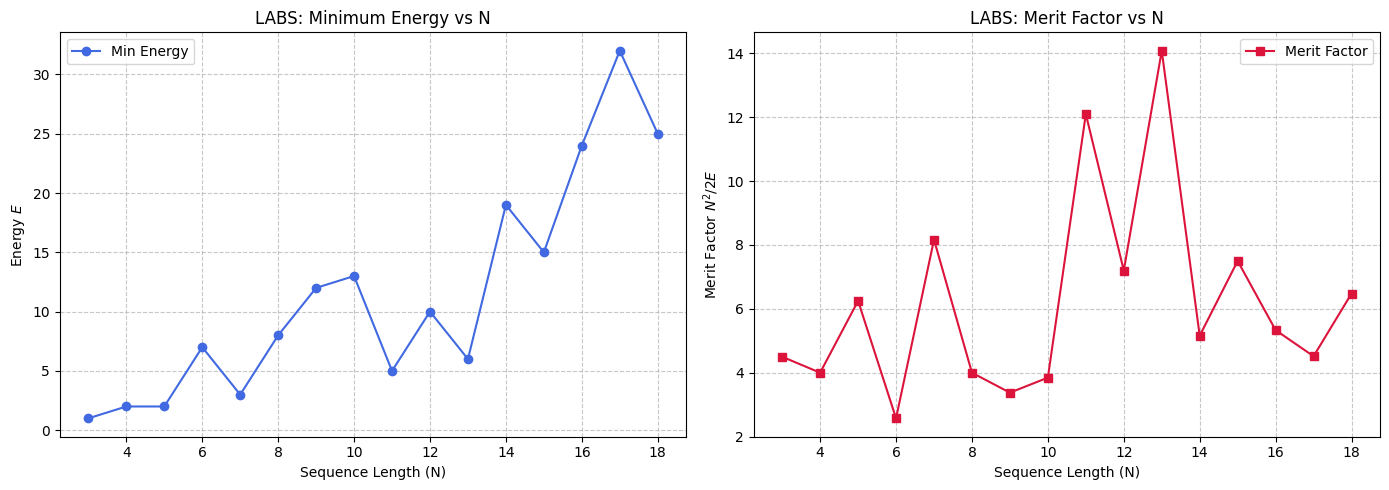

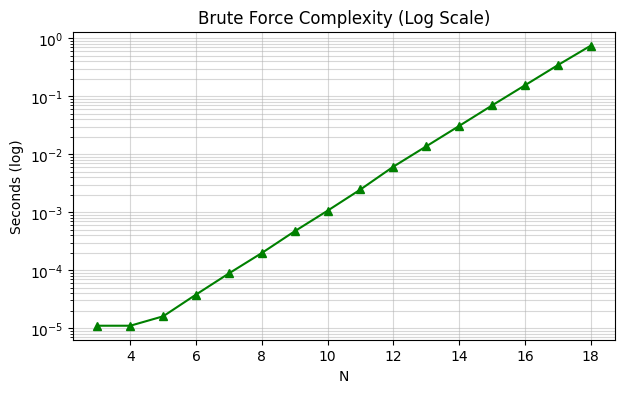

In [37]:
import itertools
import time
import matplotlib.pyplot as plt

def calculate_labs_energy(s):
    """Calculates E(s) = sum(Ck^2) for a given sequence."""
    N = len(s)
    total_energy = 0
    for k in range(1, N):
        ck = 0
        for i in range(N - k):
            ck += s[i] * s[i + k]
        total_energy += ck**2
    return total_energy

def solve_labs_brute_force(N):
    """Explores all 2^N sequences to find the global minimum."""
    start_time = time.time()
    best_energy = float('inf')
    
    # Fixing first bit to 1 reduces search space to 2^(N-1)
    for bits in itertools.product([1, -1], repeat=N-1):
        s = (1,) + bits
        current_energy = calculate_labs_energy(s)
        if current_energy < best_energy:
            best_energy = current_energy

    end_time = time.time()
    mf = (N**2) / (2 * best_energy) if best_energy > 0 else float('inf')
    
    return best_energy, round(mf, 4), round(end_time - start_time, 6)

# --- Configuration ---
N_range = range(3, 19) # Range of N values to plot
energies = []
merit_factors = []
times = []

print(f"{'N':<5} | {'Min Energy':<12} | {'Merit Factor':<15} | {'Time (s)':<10}")
print("-" * 50)

# --- Data Collection ---
for n in N_range:
    e, mf, t = solve_labs_brute_force(n)
    energies.append(e)
    merit_factors.append(mf)
    times.append(t)
    print(f"{n:<5} | {e:<12} | {mf:<15} | {t:<10}")

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Minimum Energy (Lower is better)
ax1.plot(N_range, energies, marker='o', linestyle='-', color='royalblue', label='Min Energy')
ax1.set_title('LABS: Minimum Energy vs N', fontsize=12)
ax1.set_xlabel('Sequence Length (N)')
ax1.set_ylabel('Energy $E$')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot 2: Merit Factor (Higher is better)
ax2.plot(N_range, merit_factors, marker='s', linestyle='-', color='crimson', label='Merit Factor')
ax2.set_title('LABS: Merit Factor vs N', fontsize=12)
ax2.set_xlabel('Sequence Length (N)')
ax2.set_ylabel('Merit Factor $N^2 / 2E$')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

# Bonus: Time Complexity Plot (to show why we need Quantum Algorithms)
plt.figure(figsize=(7, 4))
plt.semilogy(N_range, times, marker='^', color='green', label='Execution Time')
plt.title('Brute Force Complexity (Log Scale)')
plt.xlabel('N')
plt.ylabel('Seconds (log)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## Brute Force vs Quantum IQA 

N     | BF MF      | IQA MF    
------------------------------
3     | 4.5000     | 4.5000    
4     | 4.0000     | 4.0000    
5     | 6.2500     | 6.2500    
6     | 2.5714     | 2.5714    
7     | 8.1667     | 2.2273    
8     | 4.0000     | 4.0000    
9     | 3.3750     | 2.5312    
10    | 3.8462     | 2.3810    


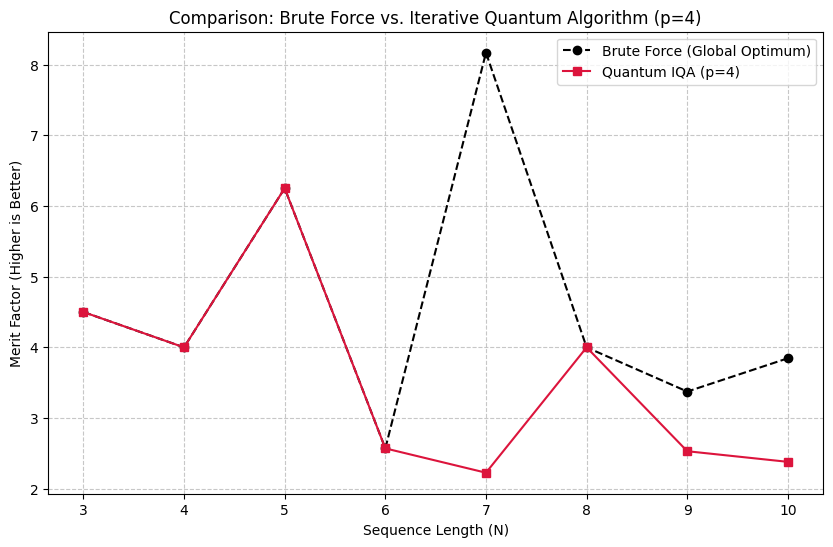

In [ ]:

# --- 1. Classical Merit Factor Calculation ---
def calculate_merit_factor(sequence):
    N = len(sequence)
    total_energy = 0
    for k in range(1, N):
        autocorrelation = 0
        for j in range(N - k):
            autocorrelation += sequence[j] * sequence[j+k]
        total_energy += autocorrelation**2
    return (N**2) / (2 * total_energy) if total_energy > 0 else float('inf')

# --- 2. Brute Force Baseline (for comparison) ---
def get_bf_merit_factor(N):
    best_energy = float('inf')
    for bits in itertools.product([1, -1], repeat=N-1):
        s = (1,) + bits
        total_energy = 0
        for k in range(1, N):
            ck = 0
            for i in range(N - k):
                ck += s[i] * s[i + k]
            total_energy += ck**2
        if total_energy < best_energy:
            best_energy = total_energy
    return (N**2) / (2 * best_energy) if best_energy > 0 else float('inf')

# --- 3. Quantum ---
@cudaq.kernel
def labs_kernel_p(qubit_count: int, p: int, params: list[float], 
                  term_indices: list[int], term_coeffs: list[float], term_sizes: list[int]):
    qset = cudaq.qvector(qubit_count)
    h(qset) 
    for layer in range(p):
        gamma = params[2 * layer]
        beta = params[2 * layer + 1]
        idx_ptr = 0
        for i in range(len(term_sizes)):
            size = term_sizes[i]
            coeff = term_coeffs[i]
            angle = 2.0 * gamma * coeff
            if size == 1:
                rz(angle, qset[term_indices[idx_ptr]])
            elif size > 1:
                for j in range(size - 1):
                    x.ctrl(qset[term_indices[idx_ptr + j]], qset[term_indices[idx_ptr + j + 1]])
                rz(angle, qset[term_indices[idx_ptr + size - 1]])
                for j in range(size - 2, -1, -1):
                    x.ctrl(qset[term_indices[idx_ptr + j]], qset[term_indices[idx_ptr + j + 1]])
            idx_ptr += size
        for i in range(qubit_count):
            rx(2.0 * beta, qset[i])

# --- 4. Problem Reduction Logic ---
def get_labs_hamiltonian(N, fixed_bits):
    term_indices, term_coeffs, term_sizes = [], [], []
    host_ham = 0.0 * spin.i(0)
    for k in range(1, N):
        for j in range(N - k):
            for m in range(j + 1, N - k):
                raw_indices = [j, j + k, m, m + k]
                counts = {}
                coeff = 1.0
                for idx in raw_indices:
                    if idx in fixed_bits: coeff *= float(fixed_bits[idx])
                    else: counts[idx] = counts.get(idx, 0) + 1
                active = [idx for idx, count in counts.items() if count % 2 != 0]
                if not active:
                    host_ham += coeff * spin.i(0)
                else:
                    term_sizes.append(len(active))
                    term_coeffs.append(coeff)
                    term_indices.extend(active)
                    term_op = coeff * spin.i(0)
                    for idx in active: term_op *= spin.z(idx)
                    host_ham += term_op
    if not term_sizes:
        host_ham += 1e-6 * spin.z(0)
        term_indices, term_coeffs, term_sizes = [0], [1e-6], [1]
    return host_ham, term_indices, term_coeffs, term_sizes

# --- 5. Iterative Solver ---
def run_iterative_labs(N, p=2):
    sequence = np.zeros(N, dtype=int)
    fixed_bits = {0: 1} 
    sequence[0] = 1
    while len(fixed_bits) < N:
        remaining = [i for i in range(N) if i not in fixed_bits]
        host_ham, t_idx, t_coeff, t_size = get_labs_hamiltonian(N, fixed_bits)
        def objective(params):
            res = cudaq.observe(labs_kernel_p, host_ham, N, p, params.tolist(), t_idx, t_coeff, t_size)
            return res.expectation()
        init_guess = [0.15, 0.15] * p 
        opt_res = minimize(objective, init_guess, method='COBYLA', options={'maxiter': 30})
        opt_params = opt_res.x
        best_bit, max_bias, prediction = -1, -1.0, 0
        for i in remaining:
            bias = cudaq.observe(labs_kernel_p, spin.z(i), N, p, opt_params.tolist(), t_idx, t_coeff, t_size).expectation()
            if abs(bias) >= max_bias:
                max_bias, best_bit = abs(bias), i
                prediction = 1 if bias >= 0 else -1
        fixed_bits[best_bit] = prediction
        sequence[best_bit] = prediction
    return sequence

# --- 6. Plotting Loop ---
N_values = range(3, 11) # Range of sequence lengths
p_depth = 4            # Circuit depth to test

results_bf = []
results_iqa = []

print(f"{'N':<5} | {'BF MF':<10} | {'IQA MF':<10}")
print("-" * 30)

for n in N_values:
    # 1. Get Brute Force Baseline
    mf_bf = get_bf_merit_factor(n)
    results_bf.append(mf_bf)
    
    # 2. Get Quantum IQA Result
    seq_iqa = run_iterative_labs(n, p=p_depth)
    mf_iqa = calculate_merit_factor(seq_iqa)
    results_iqa.append(mf_iqa)
    
    print(f"{n:<5} | {mf_bf:<10.4f} | {mf_iqa:<10.4f}")

# --- 7. Generate Plot ---
plt.figure(figsize=(10, 6))
plt.plot(N_values, results_bf, label='Brute Force (Global Optimum)', marker='o', color='black', linestyle='--')
plt.plot(N_values, results_iqa, label=f'Quantum IQA (p={p_depth})', marker='s', color='crimson')

plt.title(f'Comparison: Brute Force vs. Iterative Quantum Algorithm (p={p_depth})')
plt.xlabel('Sequence Length (N)')
plt.ylabel('Merit Factor (Higher is Better)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Possible Improvements

- Instead of running the minimize function once per bit, run it 3–5 times with different random values. Pick the best opt_params before deciding which bit to fix. This ensures the "opinion" of the quantum computer is actually the best one available at that depth.
- Increase the depth (p) using nvidia gpu. I didn't have time to try it during this event
- Use Counterdiabatic QAOA 
- Merge the IQA idea to create initial populations for the Memetic Tabu search (MTS)